In [118]:
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import numpy as np
import warnings
import json
warnings.simplefilter(action='ignore')

In [119]:
start_year = 2024
backtest_start = start_year - 1 # 回測是這個+1
backtest_end = backtest_start-2
quadrant_class_start_date = pd.to_datetime(f"{backtest_end}-01-01")
start = quadrant_class_start_date-timedelta(days=90)
quadrant_class_end_date   = pd.to_datetime(f"{backtest_start}-12-31")
# 如果要測2020年全年的績效（用2019以前的數字 
# => quad_end   = 2020-12-31
# => quad_start = 2018-01-01

In [120]:
# 獲得分類所需資料期間： 2017-01-01 == 2021-12-31
# 往前outsample期間： 2022-01-01 == 2022-12-31

# signal_quadrant 所需期間：不限（甚至可以提前存起來）

'''
需要前五年數據得到股票分類 
需要前三年數據得到象限分類 2019-01-01 == 2021-12-31, 
    因為count_return的關係必須再有往前60個交易日的資料．
'''
with open(f"farrell_for{backtest_start+1}_top100_cluster9.json", "r") as f:
    data = json.load(f)

etf_list = data
def get_etf_list(etf_list):
    all_etf_list = []
    for etf in etf_list.values():
        all_etf_list.extend(etf)
    return all_etf_list
etfs = get_etf_list(etf_list)

In [121]:

def get_data_from_yfinance(pool: list, start="1980-01-01", end=datetime.now()) -> pd.DataFrame:
    df = yf.download(pool, start=start, end=end, ignore_tz=True, progress=False)
    Adj_rate = df['Adj Close']/df['Close']
    for column in ['Close', 'Open', 'High', 'Low']:
        df[column] *= Adj_rate
        df[column] = df[column].ffill()  # fill forward 
    return df.loc[:, (slice(None), pool)]['Close']  

def count_return(df_etfs,etf_list):
    df_etf = df_etfs[df_etfs.columns.intersection(etf_list)]
    df_etf['equal_weight_sum'] = df_etf.sum(axis=1)
    for etf in df_etf.columns:
        df_etf[str(etf)+'weight'] = df_etf[str(etf)]**2/df_etf['equal_weight_sum']
    df_etf['value_weight_sum'] =df_etf.iloc[:,(len(etf_list)+1):].sum(axis=1)
    df_etf['d_ew_return'] = df_etf['equal_weight_sum'].pct_change()
    df_etf['w_ew_return'] = df_etf['equal_weight_sum'].pct_change(periods=5)
    df_etf['m_ew_return'] = df_etf['equal_weight_sum'].pct_change(periods=20)
    df_etf['q_ew_return'] = df_etf['equal_weight_sum'].pct_change(periods=60)
    df_etf['d_vw_return'] = df_etf['value_weight_sum'].pct_change()
    df_etf['w_vw_return'] = df_etf['value_weight_sum'].pct_change(periods=5)
    df_etf['m_vw_return'] = df_etf['value_weight_sum'].pct_change(periods=20)
    df_etf['q_vw_return'] = df_etf['value_weight_sum'].pct_change(periods=60)
    df_etf.dropna(inplace=True)
    return df_etf

In [122]:
df_close = get_data_from_yfinance(etfs, start=start, end=quadrant_class_end_date)
df_close_dropna = df_close.dropna()
if len(df_close_dropna) == len(df_close):
    print("stock init date test passed")
    print(df_close.index[0])
else:
    print(f"one of the stocks' init date later than {quadrant_class_start_date}")


stock init date test passed
2020-10-05 00:00:00


In [123]:
returns_dict = {}
etf_names = list(etf_list.keys())

for etf_name in etf_names:
    returns_dict[etf_name] = count_return(df_close,etf_list[etf_name])

In [124]:
# jimmy
def get_quadrants_v2(short_period = 250, long_period=750 , start='2013-01-01', end=datetime.now()):

    '''
    回測改變short/long period
    '''
    # 大盤前三年累積報酬率(市場狀態)
    # twse_index = yf.download('^TWII',start="2000-06-15", end='2019-12-31')
    twse_index = yf.download('^SPX',start=start, end=end, progress=False)
    # print(len(twse_index[twse_index.index >= "2003-06-30"]))
    twse_index['Close_3y_b'] = twse_index['Close'].shift(long_period)
    twse_index['Close_1y_b'] = twse_index['Close'].shift(short_period)
    # twse_index['ret_3y'] = twse_index['Close']/twse_index['Close_3y_b'] - 1
    # twse_index['ret_1y'] = twse_index['Close']/twse_index['Close_1y_b'] - 1
    twse_index['pct_change'] = twse_index['Close'].pct_change()
    # twse_index['ret_cum_3y'] = (1+twse_index['pct_change']).rolling(window=750).agg(lambda x : x.prod()) -1
    twse_index['ret_3y'] = twse_index['pct_change'].rolling(long_period).sum()
    twse_index['ret_1y'] = twse_index['pct_change'].rolling(short_period).sum()
    twse_index['std_3y'] = twse_index['pct_change'].rolling(window=long_period).std()
    twse_index['std_1y'] = twse_index['pct_change'].rolling(window=short_period).std()
    twse_index['vol'] = twse_index['ret_1y'] - twse_index['ret_3y']
    # twse_index = twse_index[twse_index.index >= pd.to_datetime(start)+timedelta(days=365*3)]
    # print(len(twse_index))
    # twse_index.dropna(inplace=True)
    # 波動度
    cum_return_3Y = twse_index['ret_3y']
    volatility = twse_index['vol']
    
    
    quadrant = []

    for i in range(len(twse_index)):
        if cum_return_3Y[i]>0 and volatility[i]>0:
            quadrant.append(1)
        elif cum_return_3Y[i]<0 and volatility[i]>0:
            quadrant.append(2)
        elif cum_return_3Y[i]<0 and volatility[i]<0:
            quadrant.append(3)
        elif cum_return_3Y[i]>0 and volatility[i]<0:
            quadrant.append(4)
        else:
            quadrant.append(5)

    twse_index['signal'] = quadrant
    return twse_index


In [125]:
twse = get_quadrants_v2(short_period=20, long_period=60)
twse.dropna(inplace=True)
total_signals = {}
for i in range(1, 6):
    total_signals[f'total_signal_q{i}'] = twse[twse['signal'] == i].index

twse.signal.value_counts(), twse.index[0]


(signal
 4    1866
 2     435
 1     294
 3     209
 Name: count, dtype: int64,
 Timestamp('2013-04-01 00:00:00'))

In [126]:
def get_performence(returns_dict, date_list,freq='d'):
    etf_perfs_dict = {}
    etf_names = list(returns_dict.keys())
    for etf_name in etf_names:
        etf = returns_dict[etf_name]
        etf_perfs_dict[etf_name] = [etf[etf.index.isin(date_list)][f'{freq}_ew_return'].mean(),etf[etf.index.isin(date_list)][f'{freq}_ew_return'].sem(),etf[etf.index.isin(date_list)][f'{freq}_ew_return'].median(),
                    etf[etf.index.isin(date_list)][f'{freq}_vw_return'].mean(),etf[etf.index.isin(date_list)][f'{freq}_vw_return'].sem(),etf[etf.index.isin(date_list)][f'{freq}_vw_return'].median()]
    
    etf_perfs = pd.DataFrame(etf_perfs_dict, index = ['equal_weight_mean','equal_weight_se','equal_weight_median','value_weight_mean','value_weight_se','value_weight_median']).T
    return etf_perfs

def strategy(df_perf, benchmark='value_weight_mean'):
    buy_etf = df_perf[benchmark].idxmax()
    sell_etf = df_perf[benchmark].idxmin()
    return [buy_etf, sell_etf]

In [127]:
### 用當下過去三年數據算分類
# parameter
year = 3
backtest_period = 250*year
# 多久檢查一次分類(和多久換股一次不一樣)
'''
# by day
iteration = 1

# by week
iteration = 5

# by 4 week
iteration = 20

# by quarter(12 weeks)
iteration = 60
'''
iteration = 1
freq = "d"
total = {}
iter_datetime = twse.index[(twse.index >= quadrant_class_end_date) & (twse.index <= quadrant_class_end_date+timedelta(days=365))]
list_4q = [] # 紀錄每次iteration分類，一樣的話就忽略
a = ['equal_weight_mean','equal_weight_median','value_weight_mean','value_weight_median']
b = ['equal_weight_median','value_weight_median']
for benchmark in a:
    holdings = {} # 紀錄 {datetime: list_4q}，包含 list_4q 所有變動，datetime是分類生效的日期，用datetime的前一個交易日的數據算的

    for i in range(int((len(iter_datetime))/iteration)):
        max_date = iter_datetime[i*iteration]
        min_date = pd.to_datetime(max_date) - timedelta(days=365*3)
        
        q1_dt = [date for date in list(total_signals.values())[0] if date < max_date and date >= min_date]
        q2_dt = [date for date in list(total_signals.values())[1] if date < max_date and date >= min_date]
        q3_dt = [date for date in list(total_signals.values())[2] if date < max_date and date >= min_date]
        q4_dt = [date for date in list(total_signals.values())[3] if date < max_date and date >= min_date]
        # print(max_date, min_date)
        # 用過去數據，算 max_date 當天的策略
        etf_q1 = strategy(get_performence(returns_dict, q1_dt, freq),benchmark=benchmark)
        etf_q2 = strategy(get_performence(returns_dict, q2_dt, freq),benchmark=benchmark)
        etf_q3 = strategy(get_performence(returns_dict, q3_dt, freq),benchmark=benchmark)
        etf_q4 = strategy(get_performence(returns_dict, q4_dt, freq),benchmark=benchmark)
        list_ = [etf_q1,etf_q2, etf_q3, etf_q4]
        if list_4q != list_:
            list_4q = list_
            print(max_date, list_4q)
        holdings[max_date.strftime("%Y-%m-%d")] = list_4q
    total[benchmark] = holdings

class_json = f"for{backtest_start+1}_quads_F100C9BM2_freq_{freq}.json"
with open(class_json, "w") as f:
    json.dump(total, f, indent=4)

2024-01-02 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class4', 'class0']]


2024-01-16 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class4', 'class7']]
2024-02-20 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class3', 'class7']]
2024-03-01 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class3', 'class5']]
2024-03-04 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class3', 'class7']]
2024-03-05 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class3', 'class8']]
2024-03-08 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class3', 'class7']]
2024-04-08 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class4', 'class7']]
2024-04-22 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class4', 'class8']]
2024-04-29 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class3', 'class8']]
2024-04-30 00:00:00

In [128]:

# ETF1:國內成分證券 ETF
def getNavSeries(df_now_for_nav, weighting, nav_current = 1, short=False):
    if short:
        df2 = (1 - df_now_for_nav.pct_change()).cumprod()
    else:

        df2 = (1 + df_now_for_nav.pct_change()).cumprod()
    # print(df2)
    df3 = df2.fillna(1)
    df4 = df3*nav_current
    nav_series = np.sum(df4 * weighting, axis=1)
    nav = nav_series.iloc[-1]
    return nav_series, nav

def subplots_x_y(total):
    x = np.sqrt(total)
    y = total/x
    if y == np.round(y):
        y = int(y)
    else:
        y = int(y) + 1
    if x == np.round(x):
        x = int(x) + 1
    else:
        x = int(x) + 1
    return x, y

[*********************100%%**********************]  1 of 1 completed


['2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-16', '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-22', '2024-01-23', '2024-01-24', '2024-01-25', '2024-01-26', '2024-01-29', '2024-01-30', '2024-01-31', '2024-02-01', '2024-02-02', '2024-02-05', '2024-02-06', '2024-02-07', '2024-02-08', '2024-02-09', '2024-02-12', '2024-02-13', '2024-02-14', '2024-02-15', '2024-02-16', '2024-02-20', '2024-02-21', '2024-02-22', '2024-02-23', '2024-02-26', '2024-02-27', '2024-02-28', '2024-02-29', '2024-03-01', '2024-03-04', '2024-03-05', '2024-03-06', '2024-03-07', '2024-03-08', '2024-03-11', '2024-03-12', '2024-03-13', '2024-03-14', '2024-03-15', '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21', '2024-03-22', '2024-03-25', '2024-03-26', '2024-03-27', '2024-03-28', '2024-04-01', '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-08', '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12', '2024

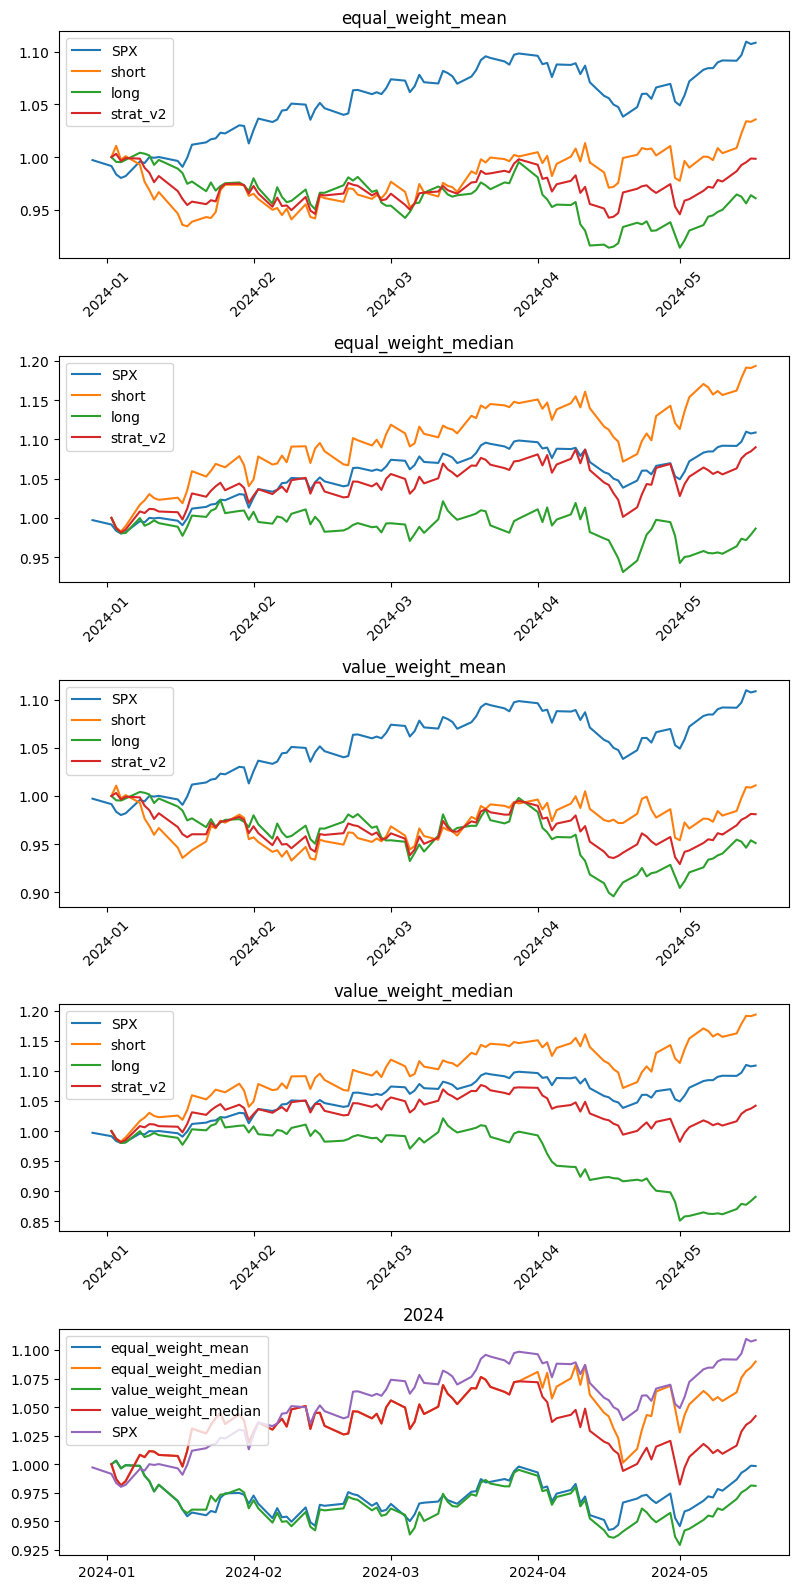

In [137]:

with open(class_json, "r") as f:
    list_strat = json.load(f)
start = pd.to_datetime(list(list_strat[list(list_strat.keys())[0]].keys())[0]) - timedelta(days=1200)
end = pd.to_datetime(list(list_strat[list(list_strat.keys())[0]].keys())[-1])

fig, ax = plt.subplots(5, 1, figsize=(8, 16))

# monthly: interval=20
interval = 10
fee = 0.0
df_close = get_data_from_yfinance(etfs, start=quadrant_class_end_date-timedelta(days=3), end=quadrant_class_end_date+timedelta(days=365))


with open(class_json, "r") as f:
    benchmark_dicts = json.load(f)
benchmarks = list(benchmark_dicts.keys())
spx_close = yf.download("^SPX", start=quadrant_class_end_date-timedelta(days=3), end=quadrant_class_end_date+timedelta(days=365))['Adj Close']

for benchmark_iter, benchmark in enumerate(benchmarks):

    list_da = []
    
    '''
    params init
    '''
    trade_list_buy = {}
    trade_list_sell = {}
    nav_all = pd.Series()
    nav_current = 1

    nav_all_short = pd.Series()
    nav_current_short = 1
    sell_current_list = []
    buy_current_list = []
    list_strat = benchmark_dicts[benchmark]
    print(list(list_strat.keys()))
    test_start = list(list_strat.keys())[0]
    test_da = df_close[df_close.index >= test_start].index[::interval]
    start = pd.to_datetime(list(list_strat.keys())[0]) - timedelta(days=1200)
    end = pd.to_datetime(list(list_strat.keys())[-1])

    for index, da in enumerate(test_da):
        signal = int(twse[twse.index == da.strftime("%Y-%m-%d")].signal[0])
        buy_sell = list_strat[da.strftime("%Y-%m-%d")]
        buy_cls = etf_list[buy_sell[signal-1][1]] # buy ETFs
        sell_cls = etf_list[buy_sell[signal-1][0]] # sell ETFs
        
        if buy_current_list != buy_cls:
            fee_long = fee
            buy_current_list = buy_cls
            trade_list_buy[da] = [signal, buy_sell[signal-1][0]]
        else:
            fee_long = 0
        if sell_current_list != sell_cls:
            fee_short = fee
            sell_current_list = sell_cls
            trade_list_sell[da] = [signal, buy_sell[signal-1][1]]
        else:
            fee_short = 0
            
        if index == len(test_da) - 1:
            nav_df = df_close[buy_cls][(df_close.index >= da) & (df_close.index <= da + timedelta(days=30))]
            
            nav_df_short = df_close[sell_cls][(df_close.index >= da) & (df_close.index <= da + timedelta(days=30))]
        else:
            nav_df = df_close[buy_cls][(df_close.index >= da) & (df_close.index <= test_da[index+1])]
            nav_df_short = df_close[sell_cls][(df_close.index >= da) & (df_close.index <= test_da[index+1])]
        nav_df.dropna(axis=1, inplace=True)
        etf_objs = len(nav_df.columns)
        weighting = [1/etf_objs]*etf_objs
        nav_series, nav_current = getNavSeries(nav_df, weighting, nav_current)
        nav_series = nav_series * (1 - fee_long)
        nav_current = nav_current * (1 - fee_long)
        nav_all = pd.concat([nav_all, nav_series], axis=0)
        # ========================================

        nav_df_short.dropna(axis=1, inplace=True)
        etf_objs_short = len(nav_df_short.columns)
        weighting_short = [1/etf_objs_short]*etf_objs_short
        nav_series_short, nav_current_short = getNavSeries(nav_df_short, weighting_short, nav_current_short, short=True)
        nav_series_short = nav_series_short * (1 - fee_short)
        nav_current_short = nav_current_short * (1 - fee_short)
        nav_all_short = pd.concat([nav_all_short, nav_series_short], axis=0)
        # ========================================
    spx = (1+spx_close.pct_change()).cumprod()
    ax[benchmark_iter].plot(spx, label='SPX')
    ax[benchmark_iter].plot(nav_all_short, label='short')

    ax[benchmark_iter].tick_params(axis='x', rotation=45)
    ax[benchmark_iter].plot(nav_all, label='long')
    ax[benchmark_iter].set_title(benchmark)
    strat = (nav_all + nav_all_short)/2
    ax[benchmark_iter].plot(strat, label='strat_v2')
    ax[benchmark_iter].legend()

    ax[4].plot(strat, label=benchmark)
    for i in list(trade_list_sell.keys()):
        ax[benchmark_iter].axvline(i, color="b")

    for i in list(trade_list_buy.keys()):
        ax[benchmark_iter].axvline(i, color="r")
    print(benchmark, trade_list_buy)

ax[4].plot(spx, label='SPX')
ax[4].set_title(backtest_start+1)
ax[4].legend()

plt.tight_layout()

Conclusion: long only for stock, equal_weight_mean for class selection

[0.33, 0.0, 0.67]